In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from demo import make_animation
from skimage import img_as_ubyte

In [2]:
import imageio

In [3]:
from demo import load_checkpoints

import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from skimage.color import rgba2rgb
from IPython.display import HTML
import warnings

from preprocessing_davis import crop_video_using_path
from preprocessing_davis import *

from preprocessing_aanet import display_video

from preprocessing_aanet import mask_image
from preprocessing_aanet import bbox2squared
import copy

In [4]:
from preprocessing_aanet import display_aaresult

> for aa.inference.py

In [5]:
import warnings
warnings.filterwarnings("ignore")
import os
from demo import make_animation
from demo import load_checkpoints
from skimage import img_as_ubyte
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.color import rgba2rgb
import copy
import imageio



### Inference (이따 삭제)

> 환경변수 확인

In [6]:
cd ..

/home/mskang/jinsu/tobigs-image-conference


In [8]:
import glob
from vos.test import *

import os, sys
import os.path
import numpy as np
import cv2
import pickle

from vi.model import generate_model
from vi.vi_inference import VIInference
from AANet.aa_inference import AAInference # 0709 추가, AANet

### a. CLASS

In [371]:
from AANet.preprocessing_aanet import *

In [131]:
import warnings
warnings.filterwarnings("ignore")
import os
from demo import make_animation
from demo import load_checkpoints
from skimage import img_as_ubyte
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.color import rgba2rgb
import copy
import imageio

# 기타 필요 함수들.
from AANet.preprocessing_aanet import *

class AAInference:
    
    def __init__(self, config_path, model_path): # 후에 args로 넣을 수도
        
        self.generator, self.region_predictor, self.avd_network = load_checkpoints(config_path=config_path,
                                                            checkpoint_path=model_path)
        
        self.source_image=None
        self.source_image_bbox=[]
        self.source_object_image=None
        self.source_image_384=None
        self.source_image_384_bbox=[]
        
        
        
        self.origin_video=[]
        self.origin_video_pos=[]
        self.origin_video_sz=[]
        self.origin_video_mask=[]
        
        self.origin_video_512=[]
        self.origin_video_pos_512=[]
        self.origin_video_sz_512=[]
        self.origin_video_mask_512=[]
        
        self.origin_video_expand_bbox=[]
        self.vi_result=[]
        
        self.driving_video=[]
        self.driving_video_384=[]
        self.driving_video_384_mask=[]
        
        # 인물 비율 테스트용
        self.keep_aspect_ratio=True
        self.aspect_ratio=1
        self.width_ratio=1
        self.for_test=[]
    
    
    def generate_driving_video_384(self, origin_video, origin_video_mask, origin_video_pos, origin_video_sz): # annotation이 존재하는 데이터의 경우에만 사용 가능하다. 

        train_size=256 # 384 x 384. train_size<480.
        crop_size=np.array(origin_video_sz).max()
        if train_size>crop_size:
            crop_size=train_size

        height,width=origin_video[0].shape[:2]

        new_driving_video=[]
        new_driving_video_mask=[]
        bboxes=[]

        for f in range(len(origin_video)):
            image=origin_video[f]
            anno_image=origin_video_mask[f]
            w,h=origin_video_sz[f]
            x,y=origin_video_pos[f]-(AAInf.origin_video_sz[f]/2).astype(int)


            new_image, new_annotation=crop_image_by_bbox(image, anno_image, [x,y,w,h], width, height,
                                                         train_size=train_size, crop_size=crop_size)

            new_image=mask_image(new_image, new_annotation)
            new_driving_video.append(new_image)
            new_driving_video_mask.append(new_annotation)
            bboxes.append(bbox2squared([x,y,w,h], train_size, (width, height)))

        return new_driving_video, new_driving_video_mask, bboxes
    
    def resize_for_generating_animation(self, source_image, driving_video, source_image_bbox):
        # AAInf.source_image가 직사각형인 경우, driving video와 우선 크기를 맞춰주자. 
        # keep_aspect_ratio : object의 비율 유지
        # else : 비율 변경(후술)
        
        
        
        ######
        # driving_video가 직사각형이라면 generating_driving_video 선행    
        #####
        
        
        
        x,y,w,h=source_image_bbox
        
        if source_image.shape[:2]!=driving_video[0].shape[:2]:
            print('source image is not square')
            # 비율 유지하면서 resize.. 
            if self.keep_aspect_ratio:
                print('keep aspect ratio of original image')
                
                
                post_size=driving_video[0].shape[:2][::-1]
                pad_const=int(0.2*max([w,h])) # 20%의 여유
                self.source_object_image=source_image[y:y+h, x:x+w]
                source_image_pad=pad_white(self.source_object_image, pad_const=pad_const)
                source_image=resize(source_image_pad, post_size)
                # bbox 변환
                
                self.source_image_384_bbox=resize_bbox_using_pad_white(source_image_bbox, self.source_object_image, pad_const)
                prior_size=source_image_pad.shape[:2] # pad_white의 결과 정사각형으로 나온다.
                self.source_image_384_bbox=resize_bbox(self.source_image_384_bbox, prior_size, post_size)
                
            else:
                # 0712 : 거의 안 쓸 것. 왜냐하면, 생성 후에 합성할 때 맞춰주면 그만이다. using ratio input over (512,512)
                print('change aspect ratio of object in source image')
                raise NameError('dont use change aspect ratio')
#                 # 0710 비율을 앞에 바운딩박스에서 가져올 수 있음. 비율 + 사이즈까지. 혹은 바운딩박스를 받을까
#                 new_size=tuple((np.array(driving_video[0].shape[:2])*self.aspect_ratio).astype(int))
#                 if self.width_ratio:
#                     new_size=(new_size[0], int(new_size[0]*self.width_ratio))
#                 source_image=pad_white(resize(source_image, new_size), pad_const=driving_video[0].shape[0])
# #                 source_image=resize(source_image, driving_video[0].shape[:2])
        
        # resize (아직 rgba 처리 안함.)(256,256)
        # 어차피 위에서 driving video가 (256,256) 라면 실행 하나 마나이긴 하다.(RGBA 방지일뿐.)
        source_image = resize(source_image, (256,256))[..., :3]
        self.source_image_384_bbox=resize_bbox(self.source_image_384_bbox, post_size, (256,256))
        
        driving_video = [resize(frame, (256,256))[..., :3] for frame in driving_video]
        
        self.source_image_384=source_image
        self.driving_video_384=driving_video
        
        return source_image, driving_video
    
    def generate_animation(self, source_image, driving_video, ani_mode):

        
        predictions = make_animation(source_image, driving_video, self.generator, 
                              self.region_predictor, self.avd_network, animation_mode=ani_mode) # animation_mode 
        
        
        self.for_test=[source_image, driving_video, predictions]
        
        
        return predictions
    
    def decouple_background(self, source_animation, method='naive_filtering', filter_ratio=0.8):
        
        masks=[] 
        if method=='naive_filtering':
            
            for f in range(len(self.source_animation)):
                a=(self.source_animation[f]>filter_ratio).astype(int)
                b=(((a[:, :, 0]==1 ) & (a[:, :, 1]==1) & (a[:, :, 2]==1))!=True).astype(float)
                masks.append(b)
            
        return masks
        
        
    def synthesize_object(self, masks, target_sizes, target_poses):
        # 물체가 동영상 외부로 나갈 위험성이 있을 시.
        for pad in range(30): # 30 : try to 30. 
            try:
                video=copy.deepcopy(self.vi_result)
                for f in range(len(video)):
                    w,h=target_sizes[f] # 새로 만든 animation의 크기
                    px, py=target_poses[f] # 새로 
                    cx, cy=self.origin_video_pos_512[f] # 합성은 512에 한다.

                    l, u=int(w/2)-pad, int(h/2)-pad
                    
                    # generated object의 위치를 bounding box로 받게한다면?
                    # 그러면, 아래의 add_height 등과 위의 asepct_ratio 등을 한 번에 처리 가능.
                    # 높, 낮이 조절 (양수 : 위)
                    add_height=0

                    # 좌, 우 조절 (양수 : 오른쪽)
                    add_width=0

                    # 굳이 int를 써야할까..
                    video_part=video[f][cy-u-add_height: cy+u-add_height, cx-l+add_width:cx+l+add_width]
                #     print(cy-u-2*add_height, cy+u-2*add_height)
                    ani_part=self.source_animation[f][py-u:py+u, px-l:px+l]
                    ani_part_masking=masks[f][py-u:py+u, px-l:px+l]
                    # remove

                    remover=video_part*np.broadcast_to(ani_part_masking[..., np.newaxis], ani_part_masking.shape+(3,))
                    video_part=video_part*(remover==0)

                    # sum
                    obj=mask_image(ani_part, ani_part_masking)

                    obj[obj==1]=0
                    video_part=video_part+obj

                    video[f][cy-u-add_height: cy+u-add_height, cx-l+add_width:cx+l+add_width]=video_part
                break # pad 관련 오류가 없을 시
            except:
                if pad==29:
                    raise NameError('object went off the video. adjust add_height or add_width')
                continue # plus 1 to pad
        
        return video
    

            

In [113]:
def draw_bbox(img, bbox):
    # bbox=(x,y,w,h)
    x,y,w,h=bbox
    img=PIL.Image.fromarray((img*255).astype(np.uint8))
    draw=PIL.ImageDraw.Draw(img)
    print(x,y,w,h)
    draw.rectangle([(x,y) ,(x+w, y+h)], width=10, outline=(0, 0, 0))

    plt.imshow(np.array(img))

In [114]:
def pad_white(im, pad_const=False): # im : imageio.imread로 읽은...(0~1)
    im_array=np.array(im)
    h,w=im_array.shape[:2]
    pad_length=abs(w-h)  
    
    if pad_const:
        add_pad_length=pad_const
        total_pad_length=add_pad_length+pad_length
    else:
        total_pad_length=pad_length
    
    pad_const2=np.max([w,h])+pad_const
    print(pad_const2)
    print(add_pad_length)
    
    if w>h:
        upper=np.full(((total_pad_length)//2, w, 3),1)
        lower=np.full((total_pad_length-total_pad_length//2, w, 3), 1)
        
        im_first=np.concatenate([upper, im_array, lower], axis=0)
        if not pad_const2:
            return imageio.core.util.Image(im_first)
        if pad_const2:
            left=np.full((pad_const2,add_pad_length//2, 3),1)
            right=np.full((pad_const2,add_pad_length-add_pad_length//2, 3),1)
        
            return imageio.core.util.Image(np.concatenate([left, im_first, right], axis=1))
    else:
        left=np.full((h,total_pad_length//2, 3),1)
        right=np.full((h,total_pad_length-total_pad_length//2, 3),1)
        
        im_first=np.concatenate([left, im_array, right], axis=1)

        if not pad_const2:
            return imageio.core.util.Image(im_first)
        if pad_const2:
            upper=np.full((add_pad_length//2,pad_const2, 3),1)
            lower=np.full((add_pad_length-add_pad_length//2,pad_const2, 3),1)
            return imageio.core.util.Image(np.concatenate([upper, im_first, lower], axis=0))
  

In [132]:
def resize_bbox_using_pad_white(bbox, im,  pad_const=0):
    # 단, 이 경우는 object bbox에 직접적으로 적용되는 코드다.(즉, (x,y)=(0,0)이라 가정한다.)
    # 이는, input image의 size invariance를 처리하기 위해, object에만 집중하기 위함.
    # 정사각형, 정사각형 패딩, 비율 변경(0710 해야함)까지.
    
    x,y, width, height=bbox
    
    im_array=np.array(im)
    h,w=im_array.shape[:2]
#     print(h,w)
    pad_length=abs(w-h)  
#     print(pad_length)

    if pad_const:
        add_pad_length=pad_const
#         add_pad_length=pad_const-np.max([w,h])
        total_pad_length=add_pad_length+pad_length
    else:
        total_pad_length=pad_length
    
    if w>h:
        if not pad_const:
            return  [0, total_pad_length//2, width, length]
        if pad_const:
            return [add_pad_length//2, total_pad_length//2, width, length] 
    else:
        if not pad_const:
            return [total_pad_length//2, 0, width, height]
            
        if pad_const:
            return [total_pad_length//2, add_pad_length//2, width, height]
        
        
        
        
    
    
    

In [14]:
ls

AANet/                   preprocessing_aanet.py  results/            tobigs/
config_inference.json    preprocessing_davis.py  sample/             vi/
inference.py             __pycache__/            SiamMask_DAVIS.pth  vos/
inference_with_aanet.py  README.md               source_image.png
install.sh               requirements.txt        test.png


In [239]:
parser = argparse.ArgumentParser(description='PyTorch Tracking Demo')

parser.add_argument('--resume', default='SiamMask_DAVIS.pth', type=str,
                    metavar='PATH',help='path to latest checkpoint (default: none)')
parser.add_argument('--config', dest='config', default='config_inference.json',
                    help='hyper-parameter of SiamMask and VINet in json format')
parser.add_argument('--base_path', default='./vos/data/tennis', help='datasets')
parser.add_argument('--save_path', default='./results', help='save path for modified video')
parser.add_argument('--cpu',  action='store_true', help='cpu mode')


parser.add_argument('--using_aanet', help='if wanna use animation generating')
parser.add_argument('--aanet_source_image_path', default='./AANet/sample/test.png' ,help='source image for aanet' )
parser.add_argument('--aanet_config_path', default='./AANet/config/taichi256.yaml', help='aanet_model.yaml')
parser.add_argument('--aanet_model_path', default='./AANet/checkpoints/taichi256.pth', help='aanet_model.pth')
parser.add_argument('--aanet_ani_mode', default='relative', help='ani_mode : standard, relative, avd')
args = parser.parse_args(args=[])

In [240]:
args.using_aanet=True

In [241]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

# Setup Model
cfg = load_config(args)
from vos.vos_models.custom import Custom
siammask = Custom(anchors=cfg['anchors'])
if args.resume:
    assert isfile(args.resume), 'Please download {} first.'.format(args.resume)
    siammask = load_pretrain(siammask, args.resume)

siammask.eval().to(device)
vinet, _ = generate_model(cfg['opt'])
vinet.eval()
inf = VIInference(vinet)

if args.using_aanet:
    AAInf=AAInference(args.aanet_config_path, args.aanet_model_path)

# Parse Image file
img_files = sorted(glob.glob(join(args.base_path, '*.jp*')))
# VI쪽으로 넘겨주기 위해 이미지 사이즈 변환 (w,h) = (512,512)
ims = [cv2.resize(cv2.imread(imf), (512,512)) for imf in img_files]

[2021-07-13 01:59:18,728-rk0-features.py# 67] Current training 0 layers:
	
[2021-07-13 01:59:18,730-rk0-features.py# 67] Current training 1 layers:
	
[2021-07-13 01:59:18,780-rk0-load_helper.py# 31] load pretrained model from SiamMask_DAVIS.pth
[2021-07-13 01:59:18,902-rk0-load_helper.py# 25] remove prefix 'module.'
[2021-07-13 01:59:18,904-rk0-load_helper.py# 18] used keys:356


Loading pretrained model vi/results/vinet_agg_rec/save_agg_rec_512.pth
Loaded: 166/166 params


In [242]:
x, y, w, h =170, 110, 130, 290
toc = 0


if args.using_aanet:
    AAInf.source_image=imageio.imread(args.aanet_source_image_path)
    # 0709 추가, aanet은 기본적으로 RGB 채널의 0~1 float image를 다룬다.
    AAInf.origin_video_512=[(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255) for img in ims]


In [243]:
for f, im in enumerate(ims):        
    # VI 쪽으로 이미지 넘겨주기 위해 저장하는 코드
    im_name = 'images/' + str(f).zfill(5) + '.jpg'
    cv2.imwrite(im_name, im)

    tic = cv2.getTickCount()
    if f == 0:  # init
        target_pos = np.array([x + w / 2, y + h / 2])
        target_sz = np.array([w, h])
        state = siamese_init(im, target_pos, target_sz, siammask, cfg['hp'], device=device)  # init tracker

    # 첫번째 frame부터 tracking
    state = siamese_track(state, im, mask_enable=True, refine_enable=True, device=device)
    location = state['ploygon'].flatten()
    mask = state['mask'] > state['p'].seg_thr
    
    # 0712
    if args.using_aanet:
        AAInf.origin_video_pos_512.append(state['target_pos'].astype(int))
        AAInf.origin_video_mask_512.append(mask.astype(int))

    inf.inference(im, mask)

    toc += cv2.getTickCount() - tic


toc /= cv2.getTickFrequency()
fps = f / toc
print('SiamMask Time: {:02.1f}s Speed: {:3.1f}fps (with visulization!)'.format(toc, fps))
inf.to_video("test", args.save_path)

SiamMask Time: 12.0s Speed: 5.8fps (with visulization!)
video creation end


> original_driving_video

In [244]:
x, y, w, h =300, 105, 180, 255
ims = [cv2.imread(imf) for imf in img_files]

if args.using_aanet:
    AAInf.source_image=imageio.imread(args.aanet_source_image_path)
    # 0709 추가, aanet은 기본적으로 RGB 채널의 0~1 float image를 다룬다.
    AAInf.origin_video=[(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255) for img in ims]

    
siammask = Custom(anchors=cfg['anchors'])
if args.resume:
    assert isfile(args.resume), 'Please download {} first.'.format(args.resume)
    siammask = load_pretrain(siammask, args.resume)

siammask.eval().to(device)



for f, im in enumerate(ims):        

    tic = cv2.getTickCount()
    if f == 0:  # init
        target_pos = np.array([x + w / 2, y + h / 2])
        target_sz = np.array([w, h])
        state = siamese_init(im, target_pos, target_sz, siammask, cfg['hp'], device=device)  # init tracker

    # 첫번째 frame부터 tracking
    state = siamese_track(state, im, mask_enable=True, refine_enable=True, device=device)

    mask = state['mask'] > state['p'].seg_thr

    if args.using_aanet:
        AAInf.origin_video_pos.append(state['target_pos'].astype(int))
        AAInf.origin_video_sz.append(state['target_sz'].astype(int))
        AAInf.origin_video_mask.append(mask.astype(int))
        
    toc += cv2.getTickCount() - tic


toc /= cv2.getTickFrequency()
fps = f / toc
print('SiamMask(original) Time: {:02.1f}s Speed: {:3.1f}fps (with visulization!)'.format(toc, fps))


[2021-07-13 01:59:33,478-rk0-features.py# 67] Current training 0 layers:
	
[2021-07-13 01:59:33,480-rk0-features.py# 67] Current training 1 layers:
	
[2021-07-13 01:59:33,535-rk0-load_helper.py# 31] load pretrained model from SiamMask_DAVIS.pth
[2021-07-13 01:59:33,636-rk0-load_helper.py# 25] remove prefix 'module.'
[2021-07-13 01:59:33,638-rk0-load_helper.py# 18] used keys:356


SiamMask(original) Time: 5.9s Speed: 11.7fps (with visulization!)


In [245]:
HTML(display_video(AAInf.origin_video).to_html5_video())

In [246]:
HTML(display_video(AAInf.origin_video_mask).to_html5_video())

In [247]:
def crop_image_by_bbox(image, annotation, bbox, width, height,
                       mod='park', return_mask=True, train_size=384, crop_size=384,):
    
#     train_size=train_size
# #     crop_size=crop_size
#     width,height=854, 480 # 이 때 w,h는 전체 image의 크기이다.
    
    new_xmin, new_xmax, new_ymin, new_ymax=bbox2squared(bbox, crop_size, (width, height))
    new_image=image[new_ymin:new_ymax, new_xmin:new_xmax, :]
    new_annotation=annotation[new_ymin:new_ymax, new_xmin:new_xmax]
    if train_size < crop_size:
        new_image=cv2.resize(new_image, (train_size, train_size))
        new_annotation=cv2.resize(new_annotation, (train_size, train_size))
    if return_mask==True: # 
        return new_image, new_annotation
    else:
        return new_image

In [248]:
# from preprocessing_aanet import crop_image_by_bbox

In [249]:
# crop_image_by_bbox

In [250]:
AAInf.origin_video_mask=[f.astype('uint8') for f in AAInf.origin_video_mask]

In [251]:
AAInf.driving_video_384, AAInf.driving_video_384_mask, AAInf.origin_video_expand_bboxes=AAInf.generate_driving_video_384(AAInf.origin_video, AAInf.origin_video_mask, AAInf.origin_video_pos,
                                AAInf.origin_video_sz)

In [270]:
args.aanet_ani_mode='relative'

In [271]:
# vinet의 결과 가져오기.
AAInf.vi_result=[f/255 for f in imageio.mimread(os.path.join(args.save_path,'test.mp4'))]

# bounding box of source image --> user에게 받아야 함.

#     cv2.namedWindow("SiamMask", cv2.WND_PROP_FULLSCREEN)
#     cv2.setWindowProperty("SiamMask", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
#     try:
#        source_bbox= cv2.selectROI('SiamMask', ims[0], False, False)
#        x, y, w, h = source_bbox
#     except:
#        exit()

x,y,w,h=160, 70, 280,680 
AAInf.source_image_bbox=[x,y,w,h]
source_pos = np.array([x + w / 2, y + h / 2])
source_sz = np.array([w, h])

siammask = Custom(anchors=cfg['anchors'])
if args.resume:
    assert isfile(args.resume), 'Please download {} first.'.format(args.resume)
    siammask = load_pretrain(siammask, args.resume)
siammask.eval().to(device)

state = siamese_init(AAInf.source_image, source_pos, source_sz, siammask, cfg['hp'], device=device)  # init tracker

state = siamese_track(state, AAInf.source_image, mask_enable=True, refine_enable=True, device=device)
#     location = state['ploygon'].flatten()

mask = state['mask'] > state['p'].seg_thr

AAInf.source_image_mask=mask.astype(int)
AAInf.source_image=mask_image(AAInf.source_image, AAInf.source_image_mask)

###################
# 앞에서 generate_driving_video_384를 실행했을 경우(즉, SIAM MASK를 원본 VIDEO에 대해 한 번 더 시행했을 경우)
if AAInf.driving_video_384:
    AAInf.source_image_384, AAInf.driving_video_384=AAInf.resize_for_generating_animation(AAInf.source_image, AAInf.driving_video_384, AAInf.source_image_bbox) 
else:
    print('don use driving_video_384')
    for f in range(len(AAInf.origin_video)):
         AAInf.driving_video.append(mask_image(AAInf.origin_video[f], AAInf.origin_video_mask[f]))
    AAInf.source_image_384, AAInf.driving_video_384=AAInf.resize_for_generating_animation(AAInf.source_image, AAInf.driving_video, AAInf.source_image_bbox)

tic=cv2.getTickCount()

AAInf.source_animation=AAInf.generate_animation(AAInf.source_image_384, AAInf.driving_video_384, args.aanet_ani_mode)

toc=cv2.getTickCount()-tic
toc /= cv2.getTickFrequency()
fps = len(AAInf.source_animation) / toc

print('generating animation Time: {:02.1f}s Speed: {:3.1f}fps)'.format(toc, fps))
# track position of generated object

[2021-07-13 02:02:26,196-rk0-features.py# 67] Current training 0 layers:
	
[2021-07-13 02:02:26,197-rk0-features.py# 67] Current training 1 layers:
	
[2021-07-13 02:02:26,252-rk0-load_helper.py# 31] load pretrained model from SiamMask_DAVIS.pth
[2021-07-13 02:02:26,373-rk0-load_helper.py# 25] remove prefix 'module.'
[2021-07-13 02:02:26,375-rk0-load_helper.py# 18] used keys:356


source image is not square
keep aspect ratio of original image


100%|██████████| 70/70 [00:01<00:00, 46.50it/s]

generating animation Time: 1.6s Speed: 44.2fps)


In [272]:
HTML(display_aaresult(AAInf.for_test[0],AAInf.for_test[1],AAInf.for_test[2]).to_html5_video())

In [273]:
import PIL

In [274]:
target_poses=[]
target_sizes=[]
toc=0

## siammask 
siammask = Custom(anchors=cfg['anchors'])
if args.resume:
    assert isfile(args.resume), 'Please download {} first.'.format(args.resume)
    siammask = load_pretrain(siammask, args.resume)
siammask.eval().to(device)

## 해당 boundign box는 for_test[0]을 이용해 얻을 수 있다(즉,기존 source image에 대한 bounding box를 받아 resize를 추적하면 됨)
########
x,y,w,h=AAInf.source_image_384_bbox

toc=0
# track size and position of object
for f, im in enumerate(AAInf.source_animation): 

    im=(im*255).astype(int) # SIAM MASK는 0~255
    tic = cv2.getTickCount()

    if f == 0: 
        target_pos = np.array([x + w / 2, y + h / 2])
        target_sz = np.array([w, h])
        state = siamese_init(im, target_pos, target_sz, siammask, cfg['hp'], device=device)  

    state = siamese_track(state, im, mask_enable=True, refine_enable=True, device=device)
    mask = state['mask'] > state['p'].seg_thr
    target_sizes.append(state['target_sz'].astype(int))
    target_poses.append(state['target_pos'].astype(int))
    toc += cv2.getTickCount() - tic

toc /= cv2.getTickFrequency()
fps = f / toc
print('masking generated animation Time: {:02.1f}s Speed: {:3.1f}fps'.format(toc, fps))
# get fine mask of generated object

masks=AAInf.decouple_background(AAInf.source_animation)


video=AAInf.synthesize_object(masks, target_sizes, target_poses)
# 비디오 합성 (0710 메서드화.)  


# imageio.mimsave(os.path.join(args.save_path, 'test_aanet.mp4'), [img_as_ubyte(frame) for frame in video])

[2021-07-13 02:02:31,965-rk0-features.py# 67] Current training 0 layers:
	
[2021-07-13 02:02:31,967-rk0-features.py# 67] Current training 1 layers:
	
[2021-07-13 02:02:32,017-rk0-load_helper.py# 31] load pretrained model from SiamMask_DAVIS.pth
[2021-07-13 02:02:32,116-rk0-load_helper.py# 25] remove prefix 'module.'
[2021-07-13 02:02:32,119-rk0-load_helper.py# 18] used keys:356


masking generated animation Time: 1.0s Speed: 70.0fps


In [275]:
HTML(display_video(video).to_html5_video())

In [276]:
imageio.mimsave(os.path.join('sample', '0713_256_pretrain...mp4'), [img_as_ubyte(frame) for frame in video])

###  Source to.. female

In [232]:
parser = argparse.ArgumentParser(description='PyTorch Tracking Demo')

parser.add_argument('--resume', default='SiamMask_DAVIS.pth', type=str,
                    metavar='PATH',help='path to latest checkpoint (default: none)')
parser.add_argument('--config', dest='config', default='config_inference.json',
                    help='hyper-parameter of SiamMask and VINet in json format')
parser.add_argument('--base_path', default='./vos/data/tennis', help='datasets')
parser.add_argument('--save_path', default='./results', help='save path for modified video')
parser.add_argument('--cpu',  action='store_true', help='cpu mode')


parser.add_argument('--using_aanet', help='if wanna use animation generating')
parser.add_argument('--aanet_source_image_path', default='./AANet/sample/test.png' ,help='source image for aanet' )
parser.add_argument('--aanet_config_path', default='./AANet/config/taichi256.yaml', help='aanet_model.yaml')
parser.add_argument('--aanet_model_path', default='./AANet/checkpoints/taichi256.pth', help='aanet_model.pth')
parser.add_argument('--aanet_ani_mode', default='relative', help='ani_mode : standard, relative, avd')
args = parser.parse_args(args=[])

In [233]:
args.using_aanet=True

In [234]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

# Setup Model
cfg = load_config(args)
from vos.vos_models.custom import Custom
siammask = Custom(anchors=cfg['anchors'])
if args.resume:
    assert isfile(args.resume), 'Please download {} first.'.format(args.resume)
    siammask = load_pretrain(siammask, args.resume)

siammask.eval().to(device)
vinet, _ = generate_model(cfg['opt'])
vinet.eval()
inf = VIInference(vinet)

if args.using_aanet:
    AAInf=AAInference(args.aanet_config_path, args.aanet_model_path)

# Parse Image file
img_files = sorted(glob.glob(join(args.base_path, '*.jp*')))
# VI쪽으로 넘겨주기 위해 이미지 사이즈 변환 (w,h) = (512,512)
ims = [cv2.resize(cv2.imread(imf), (512,512)) for imf in img_files]

[2021-07-13 01:57:20,302-rk0-features.py# 67] Current training 0 layers:
	
[2021-07-13 01:57:20,303-rk0-features.py# 67] Current training 1 layers:
	
[2021-07-13 01:57:20,353-rk0-load_helper.py# 31] load pretrained model from SiamMask_DAVIS.pth
[2021-07-13 01:57:20,468-rk0-load_helper.py# 25] remove prefix 'module.'
[2021-07-13 01:57:20,470-rk0-load_helper.py# 18] used keys:356


Loading pretrained model vi/results/vinet_agg_rec/save_agg_rec_512.pth
Loaded: 166/166 params


In [235]:
x, y, w, h =170, 110, 130, 290
toc = 0


if args.using_aanet:
    AAInf.source_image=imageio.imread(args.aanet_source_image_path)
    # 0709 추가, aanet은 기본적으로 RGB 채널의 0~1 float image를 다룬다.
    AAInf.origin_video_512=[(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255) for img in ims]


In [236]:
for f, im in enumerate(ims):        
    # VI 쪽으로 이미지 넘겨주기 위해 저장하는 코드
    im_name = 'images/' + str(f).zfill(5) + '.jpg'
    cv2.imwrite(im_name, im)

    tic = cv2.getTickCount()
    if f == 0:  # init
        target_pos = np.array([x + w / 2, y + h / 2])
        target_sz = np.array([w, h])
        state = siamese_init(im, target_pos, target_sz, siammask, cfg['hp'], device=device)  # init tracker

    # 첫번째 frame부터 tracking
    state = siamese_track(state, im, mask_enable=True, refine_enable=True, device=device)
    location = state['ploygon'].flatten()
    mask = state['mask'] > state['p'].seg_thr
    
    # 0712
    if args.using_aanet:
        AAInf.origin_video_pos_512.append(state['target_pos'].astype(int))
        AAInf.origin_video_mask_512.append(mask.astype(int))

    inf.inference(im, mask)

    toc += cv2.getTickCount() - tic


toc /= cv2.getTickFrequency()
fps = f / toc
print('SiamMask Time: {:02.1f}s Speed: {:3.1f}fps (with visulization!)'.format(toc, fps))
inf.to_video("test", args.save_path)

SiamMask Time: 13.3s Speed: 5.2fps (with visulization!)
video creation end


> original_driving_video

In [138]:
x, y, w, h =300, 105, 180, 255
ims = [cv2.imread(imf) for imf in img_files]

if args.using_aanet:
    AAInf.source_image=imageio.imread(args.aanet_source_image_path)
    # 0709 추가, aanet은 기본적으로 RGB 채널의 0~1 float image를 다룬다.
    AAInf.origin_video=[(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255) for img in ims]

    
siammask = Custom(anchors=cfg['anchors'])
if args.resume:
    assert isfile(args.resume), 'Please download {} first.'.format(args.resume)
    siammask = load_pretrain(siammask, args.resume)

siammask.eval().to(device)



for f, im in enumerate(ims):        

    tic = cv2.getTickCount()
    if f == 0:  # init
        target_pos = np.array([x + w / 2, y + h / 2])
        target_sz = np.array([w, h])
        state = siamese_init(im, target_pos, target_sz, siammask, cfg['hp'], device=device)  # init tracker

    # 첫번째 frame부터 tracking
    state = siamese_track(state, im, mask_enable=True, refine_enable=True, device=device)

    mask = state['mask'] > state['p'].seg_thr

    if args.using_aanet:
        AAInf.origin_video_pos.append(state['target_pos'].astype(int))
        AAInf.origin_video_sz.append(state['target_sz'].astype(int))
        AAInf.origin_video_mask.append(mask.astype(int))
        
    toc += cv2.getTickCount() - tic


toc /= cv2.getTickFrequency()
fps = f / toc
print('SiamMask(original) Time: {:02.1f}s Speed: {:3.1f}fps (with visulization!)'.format(toc, fps))


[2021-07-13 01:46:10,834-rk0-features.py# 67] Current training 0 layers:
	
[2021-07-13 01:46:10,835-rk0-features.py# 67] Current training 1 layers:
	
[2021-07-13 01:46:10,892-rk0-load_helper.py# 31] load pretrained model from SiamMask_DAVIS.pth
[2021-07-13 01:46:10,995-rk0-load_helper.py# 25] remove prefix 'module.'
[2021-07-13 01:46:10,998-rk0-load_helper.py# 18] used keys:356


SiamMask(original) Time: 6.4s Speed: 10.8fps (with visulization!)


In [139]:
HTML(display_video(AAInf.origin_video).to_html5_video())

In [140]:
HTML(display_video(AAInf.origin_video_mask).to_html5_video())

In [141]:
def crop_image_by_bbox(image, annotation, bbox, width, height,
                       mod='park', return_mask=True, train_size=384, crop_size=384,):
    
#     train_size=train_size
# #     crop_size=crop_size
#     width,height=854, 480 # 이 때 w,h는 전체 image의 크기이다.
    
    new_xmin, new_xmax, new_ymin, new_ymax=bbox2squared(bbox, crop_size, (width, height))
    new_image=image[new_ymin:new_ymax, new_xmin:new_xmax, :]
    new_annotation=annotation[new_ymin:new_ymax, new_xmin:new_xmax]
    
    if train_size < crop_size:
        new_image=cv2.resize(new_image, (train_size, train_size))
        new_annotation=cv2.resize(new_annotation, (train_size, train_size))
    if return_mask==True: # 
        return new_image, new_annotation
    else:
        return new_image

In [107]:
# from preprocessing_aanet import crop_image_by_bbox

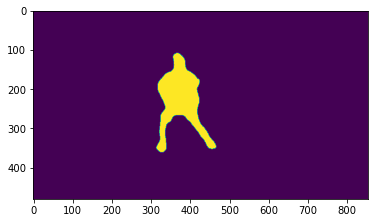

In [144]:
plt.imshow(AAInf.origin_video_mask[0])

In [150]:
cv2.resize(AAInf.origin_video_mask[0], (384,384))

error: OpenCV(4.5.2) /tmp/pip-req-build-947ayiyu/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) func != 0 in function 'resize'


In [164]:
# AAInf.origin_video_mask=[f.astype('uint8') for f in AAInf.origin_video_mask]

In [167]:
AAInf.driving_video_384, AAInf.driving_video_384_mask, AAInf.origin_video_expand_bboxes=AAInf.generate_driving_video_384(AAInf.origin_video, AAInf.origin_video_mask, AAInf.origin_video_pos,
                                AAInf.origin_video_sz)

In [76]:
# # AAInf.source_image_384_bbox

# draw_bbox(AAInf.source_image_384, AAInf.source_image_384_bbox)

In [168]:
HTML(display_video(AAInf.driving_video_384_mask).to_html5_video())

In [169]:
# args.aanet_ani_mode='avd'

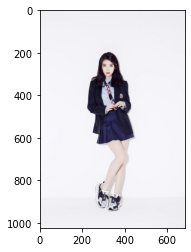

In [170]:
plt.imshow(AAInf.source_image)

In [171]:
# vinet의 결과 가져오기.
AAInf.vi_result=[f/255 for f in imageio.mimread(os.path.join(args.save_path,'test.mp4'))]

# bounding box of source image --> user에게 받아야 함.

#     cv2.namedWindow("SiamMask", cv2.WND_PROP_FULLSCREEN)
#     cv2.setWindowProperty("SiamMask", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
#     try:
#        source_bbox= cv2.selectROI('SiamMask', ims[0], False, False)
#        x, y, w, h = source_bbox
#     except:
#        exit()

x,y,w,h=200,200, 240,750 
AAInf.source_image_bbox=[x,y,w,h]
source_pos = np.array([x + w / 2, y + h / 2])
source_sz = np.array([w, h])

siammask = Custom(anchors=cfg['anchors'])
if args.resume:
    assert isfile(args.resume), 'Please download {} first.'.format(args.resume)
    siammask = load_pretrain(siammask, args.resume)
siammask.eval().to(device)

state = siamese_init(AAInf.source_image, source_pos, source_sz, siammask, cfg['hp'], device=device)  # init tracker

state = siamese_track(state, AAInf.source_image, mask_enable=True, refine_enable=True, device=device)
#     location = state['ploygon'].flatten()

mask = state['mask'] > state['p'].seg_thr

AAInf.source_image_mask=mask.astype(int)
AAInf.source_image=mask_image(AAInf.source_image, AAInf.source_image_mask)

###################
# 앞에서 generate_driving_video_384를 실행했을 경우(즉, SIAM MASK를 원본 VIDEO에 대해 한 번 더 시행했을 경우)
if AAInf.driving_video_384:
    AAInf.source_image_384, AAInf.driving_video_384=AAInf.resize_for_generating_animation(AAInf.source_image, AAInf.driving_video_384, AAInf.source_image_bbox) 
else:
    print('don use driving_video_384')
    for f in range(len(AAInf.origin_video)):
         AAInf.driving_video.append(mask_image(AAInf.origin_video[f], AAInf.origin_video_mask[f]))
    AAInf.source_image_384, AAInf.driving_video_384=AAInf.resize_for_generating_animation(AAInf.source_image, AAInf.driving_video, AAInf.source_image_bbox)

tic=cv2.getTickCount()

AAInf.source_animation=AAInf.generate_animation(AAInf.source_image_384, AAInf.driving_video_384, args.aanet_ani_mode)

toc=cv2.getTickCount()-tic
toc /= cv2.getTickFrequency()
fps = len(AAInf.source_animation) / toc

print('generating animation Time: {:02.1f}s Speed: {:3.1f}fps)'.format(toc, fps))
# track position of generated object

[2021-07-13 01:50:23,675-rk0-features.py# 67] Current training 0 layers:
	
[2021-07-13 01:50:23,677-rk0-features.py# 67] Current training 1 layers:
	
[2021-07-13 01:50:23,726-rk0-load_helper.py# 31] load pretrained model from SiamMask_DAVIS.pth
[2021-07-13 01:50:23,845-rk0-load_helper.py# 25] remove prefix 'module.'
[2021-07-13 01:50:23,847-rk0-load_helper.py# 18] used keys:356


source image is not square
keep aspect ratio of original image


100%|██████████| 70/70 [00:01<00:00, 40.85it/s]

generating animation Time: 2.0s Speed: 35.1fps)


In [173]:
import PIL

In [174]:
%matplotlib inline
draw_bbox(AAInf.source_image_384, AAInf.source_image_384_bbox)

NameError: name 'PIL' is not defined

In [175]:
HTML(display_aaresult(AAInf.for_test[0],AAInf.for_test[1],AAInf.for_test[2]).to_html5_video())

In [92]:
target_poses=[]
target_sizes=[]
toc=0

## siammask 
siammask = Custom(anchors=cfg['anchors'])
if args.resume:
    assert isfile(args.resume), 'Please download {} first.'.format(args.resume)
    siammask = load_pretrain(siammask, args.resume)
siammask.eval().to(device)

## 해당 boundign box는 for_test[0]을 이용해 얻을 수 있다(즉,기존 source image에 대한 bounding box를 받아 resize를 추적하면 됨)
########
x,y,w,h=AAInf.source_image_384_bbox

toc=0
# track size and position of object
for f, im in enumerate(AAInf.source_animation): 

    im=(im*255).astype(int) # SIAM MASK는 0~255
    tic = cv2.getTickCount()

    if f == 0: 
        target_pos = np.array([x + w / 2, y + h / 2])
        target_sz = np.array([w, h])
        state = siamese_init(im, target_pos, target_sz, siammask, cfg['hp'], device=device)  

    state = siamese_track(state, im, mask_enable=True, refine_enable=True, device=device)
    mask = state['mask'] > state['p'].seg_thr
    target_sizes.append(state['target_sz'].astype(int))
    target_poses.append(state['target_pos'].astype(int))
    toc += cv2.getTickCount() - tic

toc /= cv2.getTickFrequency()
fps = f / toc
print('masking generated animation Time: {:02.1f}s Speed: {:3.1f}fps'.format(toc, fps))
# get fine mask of generated object

masks=AAInf.decouple_background(AAInf.source_animation)


video=AAInf.synthesize_object(masks, target_sizes, target_poses)
# 비디오 합성 (0710 메서드화.)  


# imageio.mimsave(os.path.join(args.save_path, 'test_aanet.mp4'), [img_as_ubyte(frame) for frame in video])

[2021-07-13 00:23:19,254-rk0-features.py# 67] Current training 0 layers:
	
[2021-07-13 00:23:19,255-rk0-features.py# 67] Current training 1 layers:
	
[2021-07-13 00:23:19,305-rk0-load_helper.py# 31] load pretrained model from SiamMask_DAVIS.pth
[2021-07-13 00:23:19,409-rk0-load_helper.py# 25] remove prefix 'module.'
[2021-07-13 00:23:19,411-rk0-load_helper.py# 18] used keys:356


masking generated animation Time: 6.8s Speed: 10.1fps


> source image가 짤려서, 다리가 짤림

## USING DAVIS?

In [308]:
parser = argparse.ArgumentParser(description='PyTorch Tracking Demo')

parser.add_argument('--resume', default='SiamMask_DAVIS.pth', type=str,
                    metavar='PATH',help='path to latest checkpoint (default: none)')
parser.add_argument('--config', dest='config', default='config_inference.json',
                    help='hyper-parameter of SiamMask and VINet in json format')
parser.add_argument('--base_path', default='./vos/data/tennis', help='datasets')
parser.add_argument('--save_path', default='./results', help='save path for modified video')
parser.add_argument('--cpu',  action='store_true', help='cpu mode')


parser.add_argument('--using_aanet', help='if wanna use animation generating')
parser.add_argument('--aanet_source_image_path', default='./AANet/sample/test.png' ,help='source image for aanet' )
parser.add_argument('--aanet_config_path', default='./AANet/config/taichi256.yaml', help='aanet_model.yaml')
parser.add_argument('--aanet_model_path', default='./AANet/checkpoints/taichi256.pth', help='aanet_model.pth')
parser.add_argument('--aanet_ani_mode', default='relative', help='ani_mode : standard, relative, avd')
args = parser.parse_args(args=[])

In [309]:
args.using_aanet=True

In [318]:
args.base_path='AANet/sample/test_davis/original_video/lucia'

In [319]:
# url='https://i.pinimg.com/236x/cf/44/86/cf44867643deeb82f3185936cda63fe8.jpg' # 샴마스크 안 됨.
url='https://i.pinimg.com/236x/6e/4b/2e/6e4b2ebfec39a4eff4ad40b3a7dd9914.jpg'
url='https://thumb.mtstarnews.com/06/2020/06/2020062610180181240_1.jpg'
os.system("curl " + url + "> AANet/sample/rucia.png")

0

In [320]:
args.aanet_source_image_path='AANet/sample/rucia.png'

In [321]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

# Setup Model
cfg = load_config(args)
from vos.vos_models.custom import Custom
siammask = Custom(anchors=cfg['anchors'])
if args.resume:
    assert isfile(args.resume), 'Please download {} first.'.format(args.resume)
    siammask = load_pretrain(siammask, args.resume)

siammask.eval().to(device)
vinet, _ = generate_model(cfg['opt'])
vinet.eval()
inf = VIInference(vinet)

if args.using_aanet:
    AAInf=AAInference(args.aanet_config_path, args.aanet_model_path)

# Parse Image file
img_files = sorted(glob.glob(join(args.base_path, '*.jp*')))
# VI쪽으로 넘겨주기 위해 이미지 사이즈 변환 (w,h) = (512,512)
ims = [cv2.resize(cv2.imread(imf), (512,512)) for imf in img_files]

[2021-07-13 02:18:50,415-rk0-features.py# 67] Current training 0 layers:
	
[2021-07-13 02:18:50,417-rk0-features.py# 67] Current training 1 layers:
	
[2021-07-13 02:18:50,469-rk0-load_helper.py# 31] load pretrained model from SiamMask_DAVIS.pth
[2021-07-13 02:18:50,592-rk0-load_helper.py# 25] remove prefix 'module.'
[2021-07-13 02:18:50,594-rk0-load_helper.py# 18] used keys:356


Loading pretrained model vi/results/vinet_agg_rec/save_agg_rec_512.pth
Loaded: 166/166 params


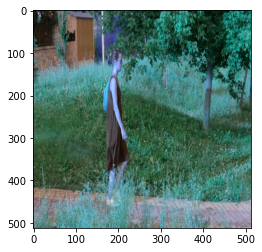

In [322]:
plt.imshow(ims[0])

In [323]:
x, y, w, h =150, 100, 100, 400
toc = 0


if args.using_aanet:
    AAInf.source_image=imageio.imread(args.aanet_source_image_path)
    # 0709 추가, aanet은 기본적으로 RGB 채널의 0~1 float image를 다룬다.
    AAInf.origin_video_512=[(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255) for img in ims]


In [324]:
for f, im in enumerate(ims):        
    # VI 쪽으로 이미지 넘겨주기 위해 저장하는 코드
    im_name = 'images/' + str(f).zfill(5) + '.jpg'
    cv2.imwrite(im_name, im)

    tic = cv2.getTickCount()
    if f == 0:  # init
        target_pos = np.array([x + w / 2, y + h / 2])
        target_sz = np.array([w, h])
        state = siamese_init(im, target_pos, target_sz, siammask, cfg['hp'], device=device)  # init tracker

    # 첫번째 frame부터 tracking
    state = siamese_track(state, im, mask_enable=True, refine_enable=True, device=device)
    location = state['ploygon'].flatten()
    mask = state['mask'] > state['p'].seg_thr
    
    # 0712
    if args.using_aanet:
        AAInf.origin_video_pos_512.append(state['target_pos'].astype(int))
        AAInf.origin_video_mask_512.append(mask.astype(int))

    inf.inference(im, mask)

    toc += cv2.getTickCount() - tic


toc /= cv2.getTickFrequency()
fps = f / toc
print('SiamMask Time: {:02.1f}s Speed: {:3.1f}fps (with visulization!)'.format(toc, fps))
inf.to_video("test", args.save_path)

SiamMask Time: 13.0s Speed: 5.3fps (with visulization!)
video creation end


> original_driving_video

In [326]:
x, y, w, h =250, 80, 150, 350
ims = [cv2.imread(imf) for imf in img_files]

if args.using_aanet:
    AAInf.source_image=imageio.imread(args.aanet_source_image_path)
    # 0709 추가, aanet은 기본적으로 RGB 채널의 0~1 float image를 다룬다.
    AAInf.origin_video=[(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255) for img in ims]

    
siammask = Custom(anchors=cfg['anchors'])
if args.resume:
    assert isfile(args.resume), 'Please download {} first.'.format(args.resume)
    siammask = load_pretrain(siammask, args.resume)

siammask.eval().to(device)



for f, im in enumerate(ims):        

    tic = cv2.getTickCount()
    if f == 0:  # init
        target_pos = np.array([x + w / 2, y + h / 2])
        target_sz = np.array([w, h])
        state = siamese_init(im, target_pos, target_sz, siammask, cfg['hp'], device=device)  # init tracker

    # 첫번째 frame부터 tracking
    state = siamese_track(state, im, mask_enable=True, refine_enable=True, device=device)

    mask = state['mask'] > state['p'].seg_thr

    if args.using_aanet:
        AAInf.origin_video_pos.append(state['target_pos'].astype(int))
        AAInf.origin_video_sz.append(state['target_sz'].astype(int))
        AAInf.origin_video_mask.append(mask.astype(int))
        
    toc += cv2.getTickCount() - tic


toc /= cv2.getTickFrequency()
fps = f / toc
print('SiamMask(original) Time: {:02.1f}s Speed: {:3.1f}fps (with visulization!)'.format(toc, fps))


[2021-07-13 02:20:10,679-rk0-features.py# 67] Current training 0 layers:
	
[2021-07-13 02:20:10,681-rk0-features.py# 67] Current training 1 layers:
	
[2021-07-13 02:20:10,734-rk0-load_helper.py# 31] load pretrained model from SiamMask_DAVIS.pth
[2021-07-13 02:20:10,857-rk0-load_helper.py# 25] remove prefix 'module.'
[2021-07-13 02:20:10,860-rk0-load_helper.py# 18] used keys:356


SiamMask(original) Time: 6.5s Speed: 10.6fps (with visulization!)


In [327]:
HTML(display_video(AAInf.origin_video).to_html5_video())

In [328]:
HTML(display_video(AAInf.origin_video_mask).to_html5_video())

In [329]:
def crop_image_by_bbox(image, annotation, bbox, width, height,
                       mod='park', return_mask=True, train_size=384, crop_size=384,):
    
#     train_size=train_size
# #     crop_size=crop_size
#     width,height=854, 480 # 이 때 w,h는 전체 image의 크기이다.
    
    new_xmin, new_xmax, new_ymin, new_ymax=bbox2squared(bbox, crop_size, (width, height))
    new_image=image[new_ymin:new_ymax, new_xmin:new_xmax, :]
    new_annotation=annotation[new_ymin:new_ymax, new_xmin:new_xmax]
    if train_size < crop_size:
        new_image=cv2.resize(new_image, (train_size, train_size))
        new_annotation=cv2.resize(new_annotation, (train_size, train_size))
    if return_mask==True: # 
        return new_image, new_annotation
    else:
        return new_image

In [330]:
# from preprocessing_aanet import crop_image_by_bbox

In [331]:
# crop_image_by_bbox

In [332]:
AAInf.origin_video_mask=[f.astype('uint8') for f in AAInf.origin_video_mask]

In [333]:
AAInf.driving_video_384, AAInf.driving_video_384_mask, AAInf.origin_video_expand_bboxes=AAInf.generate_driving_video_384(AAInf.origin_video, AAInf.origin_video_mask, AAInf.origin_video_pos,
                                AAInf.origin_video_sz)

In [334]:
args.aanet_ani_mode='relative'

In [341]:
# vinet의 결과 가져오기.
AAInf.vi_result=[f/255 for f in imageio.mimread(os.path.join(args.save_path,'test.mp4'))]

# bounding box of source image --> user에게 받아야 함.

#     cv2.namedWindow("SiamMask", cv2.WND_PROP_FULLSCREEN)
#     cv2.setWindowProperty("SiamMask", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
#     try:
#        source_bbox= cv2.selectROI('SiamMask', ims[0], False, False)
#        x, y, w, h = source_bbox
#     except:
#        exit()

x,y,w,h=200, 80, 180, 570
AAInf.source_image_bbox=[x,y,w,h]
source_pos = np.array([x + w / 2, y + h / 2])
source_sz = np.array([w, h])

siammask = Custom(anchors=cfg['anchors'])
if args.resume:
    assert isfile(args.resume), 'Please download {} first.'.format(args.resume)
    siammask = load_pretrain(siammask, args.resume)
siammask.eval().to(device)

state = siamese_init(AAInf.source_image, source_pos, source_sz, siammask, cfg['hp'], device=device)  # init tracker

state = siamese_track(state, AAInf.source_image, mask_enable=True, refine_enable=True, device=device)
#     location = state['ploygon'].flatten()

mask = state['mask'] > state['p'].seg_thr

AAInf.source_image_mask=mask.astype(int)
AAInf.source_image=mask_image(AAInf.source_image, AAInf.source_image_mask)

###################
# 앞에서 generate_driving_video_384를 실행했을 경우(즉, SIAM MASK를 원본 VIDEO에 대해 한 번 더 시행했을 경우)
if AAInf.driving_video_384:
    AAInf.source_image_384, AAInf.driving_video_384=AAInf.resize_for_generating_animation(AAInf.source_image, AAInf.driving_video_384, AAInf.source_image_bbox) 
else:
    print('don use driving_video_384')
    for f in range(len(AAInf.origin_video)):
         AAInf.driving_video.append(mask_image(AAInf.origin_video[f], AAInf.origin_video_mask[f]))
    AAInf.source_image_384, AAInf.driving_video_384=AAInf.resize_for_generating_animation(AAInf.source_image, AAInf.driving_video, AAInf.source_image_bbox)

tic=cv2.getTickCount()

AAInf.source_animation=AAInf.generate_animation(AAInf.source_image_384, AAInf.driving_video_384, args.aanet_ani_mode)

toc=cv2.getTickCount()-tic
toc /= cv2.getTickFrequency()
fps = len(AAInf.source_animation) / toc

print('generating animation Time: {:02.1f}s Speed: {:3.1f}fps)'.format(toc, fps))
# track position of generated object

[2021-07-13 02:24:11,527-rk0-features.py# 67] Current training 0 layers:
	
[2021-07-13 02:24:11,529-rk0-features.py# 67] Current training 1 layers:
	
[2021-07-13 02:24:11,580-rk0-load_helper.py# 31] load pretrained model from SiamMask_DAVIS.pth
[2021-07-13 02:24:11,699-rk0-load_helper.py# 25] remove prefix 'module.'
[2021-07-13 02:24:11,701-rk0-load_helper.py# 18] used keys:356


source image is not square
keep aspect ratio of original image


100%|██████████| 70/70 [00:01<00:00, 46.91it/s]

generating animation Time: 1.6s Speed: 43.4fps)


In [342]:
HTML(display_aaresult(AAInf.for_test[0],AAInf.for_test[1],AAInf.for_test[2]).to_html5_video())

In [343]:
target_poses=[]
target_sizes=[]
toc=0

## siammask 
siammask = Custom(anchors=cfg['anchors'])
if args.resume:
    assert isfile(args.resume), 'Please download {} first.'.format(args.resume)
    siammask = load_pretrain(siammask, args.resume)
siammask.eval().to(device)

## 해당 boundign box는 for_test[0]을 이용해 얻을 수 있다(즉,기존 source image에 대한 bounding box를 받아 resize를 추적하면 됨)
########
x,y,w,h=AAInf.source_image_384_bbox

toc=0
# track size and position of object
for f, im in enumerate(AAInf.source_animation): 

    im=(im*255).astype(int) # SIAM MASK는 0~255
    tic = cv2.getTickCount()

    if f == 0: 
        target_pos = np.array([x + w / 2, y + h / 2])
        target_sz = np.array([w, h])
        state = siamese_init(im, target_pos, target_sz, siammask, cfg['hp'], device=device)  

    state = siamese_track(state, im, mask_enable=True, refine_enable=True, device=device)
    mask = state['mask'] > state['p'].seg_thr
    target_sizes.append(state['target_sz'].astype(int))
    target_poses.append(state['target_pos'].astype(int))
    toc += cv2.getTickCount() - tic

toc /= cv2.getTickFrequency()
fps = f / toc
print('masking generated animation Time: {:02.1f}s Speed: {:3.1f}fps'.format(toc, fps))
# get fine mask of generated object

masks=AAInf.decouple_background(AAInf.source_animation)


video=AAInf.synthesize_object(masks, target_sizes, target_poses)
# 비디오 합성 (0710 메서드화.)  


# imageio.mimsave(os.path.join(args.save_path, 'test_aanet.mp4'), [img_as_ubyte(frame) for frame in video])

[2021-07-13 02:24:25,231-rk0-features.py# 67] Current training 0 layers:
	
[2021-07-13 02:24:25,232-rk0-features.py# 67] Current training 1 layers:
	
[2021-07-13 02:24:25,292-rk0-load_helper.py# 31] load pretrained model from SiamMask_DAVIS.pth
[2021-07-13 02:24:25,405-rk0-load_helper.py# 25] remove prefix 'module.'
[2021-07-13 02:24:25,409-rk0-load_helper.py# 18] used keys:356


masking generated animation Time: 1.0s Speed: 65.9fps


In [344]:
HTML(display_video(video).to_html5_video())

In [337]:
target_poses=[]
masks=[]
target_sizes=[]
toc=0
x,y,w,h=150, 30, 70, 350
# x,y,w,h=0,0,300,300
siammask = Custom(anchors=cfg['anchors'])
if args.resume:
    assert isfile(args.resume), 'Please download {} first.'.format(args.resume)
    siammask = load_pretrain(siammask, args.resume)

siammask.eval().to(device)

for f, im in enumerate(AAInf.source_animation): 
    # VI 쪽으로 이미지 넘겨주기 위해 저장하는 코드
#     im_name = 'images/' + str(f).zfill(5) + '.jpg'
#     cv2.imwrite(im_name, im)

    # SIAM MASK는 0~255
    im=(im*255).astype(int)
    tic = cv2.getTickCount()
    if f == 0:  # init
        target_pos = np.array([x + w / 2, y + h / 2])
        target_sz = np.array([w, h])
        state = siamese_init(im, target_pos, target_sz, siammask, cfg['hp'], device=device)  # init tracker

    # 첫번째 frame부터 tracking
    state = siamese_track(state, im, mask_enable=True, refine_enable=True, device=device)
#     location = state['ploygon'].flatten()
    mask = state['mask'] > state['p'].seg_thr
    # 0709 추가
    target_sizes.append(state['target_sz'].astype(int))
    target_poses.append(state['target_pos'].astype(int))
    masks.append(mask)
#     inf.inference(im, mask)

    toc += cv2.getTickCount() - tic

[2021-07-13 02:23:43,862-rk0-features.py# 67] Current training 0 layers:
	
[2021-07-13 02:23:43,864-rk0-features.py# 67] Current training 1 layers:
	
[2021-07-13 02:23:43,913-rk0-load_helper.py# 31] load pretrained model from SiamMask_DAVIS.pth
[2021-07-13 02:23:44,028-rk0-load_helper.py# 25] remove prefix 'module.'
[2021-07-13 02:23:44,031-rk0-load_helper.py# 18] used keys:356


In [338]:
masks=[]
toc=0
for f in range(len(AAInf.source_animation)):
    tic = cv2.getTickCount()
    a=(AAInf.source_animation[f]>0.80).astype(int)
    b=(((a[:, :, 0]==1 ) & (a[:, :, 1]==1) & (a[:, :, 2]==1))!=True).astype(float)
    masks.append(b)
    toc += cv2.getTickCount() - tic
    

In [339]:
import copy

In [340]:

# 물체가 동영상 외부로 나갈 위험성이 있을 시.
for pad in range(30): # 30 : try to 30. 
    try:
        video=copy.deepcopy(AAInf.vi_result)
        for f in range(len(video)):
            w,h=target_sizes[f]
            px, py=target_poses[f]
            cx, cy=AAInf.origin_video_pos[f]

            l, u=int(w/2)-pad, int(h/2)-pad

            # 높, 낮이 조절 (양수 : 위)
            add_height=0
        #     cy+=add_height

            # 좌, 우 조절 (양수 : 오른쪽)
            add_width=0


            # 굳이 int를 써야할까..
            video_part=video[f][cy-u-add_height: cy+u-add_height, cx-l+add_width:cx+l+add_width]
        #     print(cy-u-2*add_height, cy+u-2*add_height)
            ani_part=AAInf.source_animation[f][py-u:py+u, px-l:px+l]
            ani_part_masking=masks[f][py-u:py+u, px-l:px+l]
            # remove

            remover=video_part*np.broadcast_to(ani_part_masking[..., np.newaxis], ani_part_masking.shape+(3,))
            video_part=video_part*(remover==0)

            # sum
            obj=mask_image(ani_part, ani_part_masking)

            obj[obj==1]=0
            video_part=video_part+obj

            video[f][cy-u-add_height: cy+u-add_height, cx-l+add_width:cx+l+add_width]=video_part
        break # pad 관련 오류가 없을 시
    except:
        if pad==29:
            raise NameError('object went off the video. adjust add_height or add_width')
        continue # plus 1 to pad
    
    

NameError: object went off the video. adjust add_height or add_width

In [ ]:
HTML(display_video(video).to_html5_video())

In [297]:
imageio.mimsave('sample/rucia_origin_video.mp4', [img_as_ubyte(frame) for frame in AAInf.origin_video])

In [299]:
imageio.mimsave('sample/rucia_bts_1.mp4', [img_as_ubyte(frame) for frame in video])